In [ ]:
#out out 950 images of each animal, images have been split into 190 images for testing and 760 images for training

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
# fetch dataset which is uploaded on kaggle
!kaggle datasets download -d basukallapur/images

Dataset URL: https://www.kaggle.com/datasets/basukallapur/images
License(s): unknown
 99% 177M/179M [00:04<00:00, 43.3MB/s]
100% 179M/179M [00:05<00:00, 37.5MB/s]


In [7]:
# unzip dataset
import zipfile
zip_ref = zipfile.ZipFile('/content/images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Found 2280 images belonging to 3 classes.
Found 570 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                      

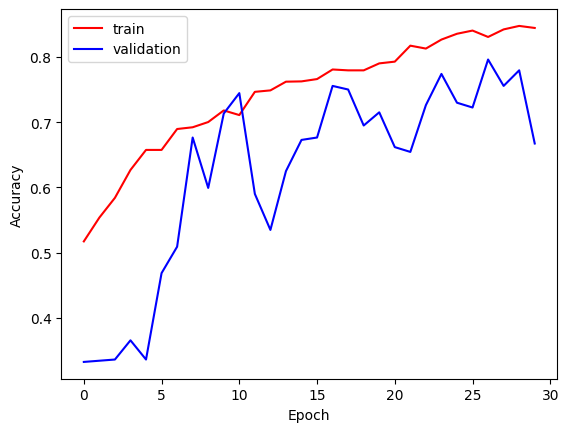

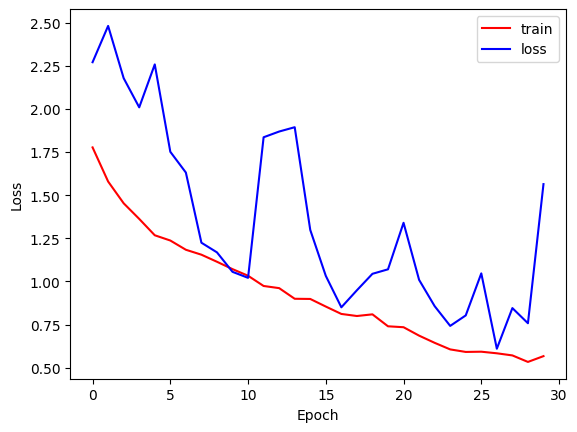

1/1 [==============================] - 1s 1s/step


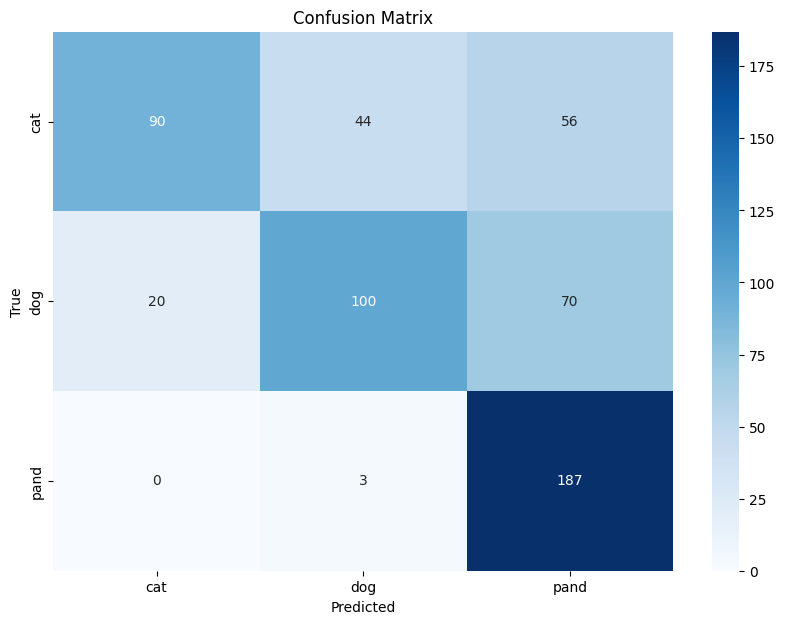

              precision    recall  f1-score   support

         cat       0.82      0.47      0.60       190
         dog       0.68      0.53      0.59       190
        pand       0.60      0.98      0.74       190

    accuracy                           0.66       570
   macro avg       0.70      0.66      0.65       570
weighted avg       0.70      0.66      0.65       570



In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/autoyos-data/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/autoyos-data/test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Create CNN model with 6 convolutional layers
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(256, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(512, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(1024, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes: cat, dog, panda

model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,  # Increase epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Plot training history
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate Confusion Matrix
# Reset the generator to start from the beginning
validation_generator.reset()

# Make Predictions on the Entire Validation Set
y_pred = []
y_true = []

# Iterate over the entire validation set
for _ in range(len(validation_generator)):
    X_batch, y_batch = validation_generator.next()
    y_pred_batch = model.predict(X_batch)
    y_pred.extend(np.argmax(y_pred_batch, axis=1))
    y_true.extend(np.argmax(y_batch, axis=1))

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))


In [ ]:
# above we have attained 79.60% validation accuracy at 27th epoch

In [14]:
# Function to predict new images
def predict_image(image_path, model):
    img = tf.keras.preprocessing.image.load_img("/content/cat11.jpeg", target_size=(256, 256))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Normalize the image

    predictions = model.predict(x)
    predicted_class = np.argmax(predictions[0])

    class_labels = {0: 'Cat', 1: 'Dog', 2: 'Panda'}
    return class_labels.get(predicted_class, 'Unknown')

# Example usage
image_path = "/content/cat11.jpeg"
predicted_label = predict_image(image_path, model)
print(f'The predicted label is: {predicted_label}')

1/1 [==============================] - 0s 19ms/step
The predicted label is: Cat
